In [9]:
'''本文参考：
    理论部分：https://kexue.fm/archives/5253
    keras版VAE：https://github.com/bojone/vae/blob/master/vae_keras.py
    torch 教程：https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
'''

'本文参考：\n    理论部分：https://kexue.fm/archives/5253\n    keras版VAE：https://github.com/bojone/vae/blob/master/vae_keras.py\n    torch 教程：https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html\n'

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

# use cuda or not
use_cuda = torch.cuda.is_available()


# normalized
transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)
train_set = dset.MNIST(root='/kaggle/working/', train=True, transform=transform1, download=True)
test_set = dset.MNIST(root='/kaggle/working/', train=False, transform=transform1, download=True)


In [11]:
#数据迭代器
train_data_loader=torch.utils.data.DataLoader(train_set,batch_size=100,\
                                              shuffle=True,num_workers=2)
test_data_loader=torch.utils.data.DataLoader(test_set,batch_size=100,\
                                             shuffle=False,num_workers=2)

torch.Size([100, 1, 28, 28])


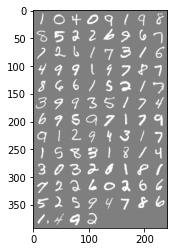

In [12]:
#可视
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))

In [13]:
import torch.nn.functional as F
class Vae(nn.Module):
    def __init__(self,input_dim,trans_dim,z_dim,intermediate_dim):
        super().__init__()
        #(28*28,256,2,256)
        
        original_dim=input_dim
        
        self.trans_func=nn.Linear(input_dim,trans_dim)
        self.z_mean_func=nn.Linear(trans_dim,z_dim)
        self.z_log_var_func=nn.Linear(trans_dim,z_dim)
        
        self.decoder_h_func=nn.Linear(z_dim,intermediate_dim)
        self.decoder_mean_func=nn.Linear(intermediate_dim,original_dim)
    def forward(self,x):
        self.encoder(x)
        self.decoder(self.z)

        return self.decoder_mean,self.z_mean,self.z_log_var
    def encoder(self,x):
        self.trans_state=F.relu(self.trans_func(x))
        self.z_mean=self.z_mean_func(self.trans_state)
        self.z_log_var=self.z_log_var_func(self.trans_state)
        # 重参数技巧
        epsilon = torch.normal(mean=0,std=1,size=(1,2))
        self.z=self.z_mean + torch.exp(self.z_log_var / 2) * epsilon
        
        return self.z
    def decoder(self,x):
        self.decoder_h=F.relu(self.decoder_h_func(x))
        self.decoder_mean=F.sigmoid(self.decoder_mean_func(self.decoder_h))
        return self.decoder_mean
        

In [14]:
vae=Vae(28*28,256,2,256)

In [15]:
import torch.optim as optim
criterion=nn.BCELoss(reduction="none")
optimizer=optim.RMSprop(vae.parameters(), lr=0.001)

In [16]:
len(train_set)

60000

In [17]:
from tqdm.notebook import tqdm
from itertools import cycle
#要跑完足够多的epoch 才有效果
epoch=50
batch_size=100
bar = tqdm(range(epoch*int(len(train_set)/batch_size)), total=epoch*int(len(train_set)/batch_size))
train_data_loader=cycle(train_data_loader)
vae.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for tdata in bar:
    data=next(train_data_loader)
    inputs,label=data

    optimizer.zero_grad()
    inputs=inputs.reshape(len(inputs),-1)
    output,z_mean,z_log_var=vae(inputs.to(device))

    xent_loss=torch.sum(criterion(output,inputs),axis=-1)
    #kl 散度（计算推导后的结果）
    kl_loss=- 0.5 * torch.sum(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var), axis=-1)
    vae_loss=torch.mean(xent_loss + kl_loss)
    vae_loss.backward()
    optimizer.step()
    vae_loss_prt=round(vae_loss.item(),4)
    bar.set_description("loss {}".format(vae_loss_prt))

        

  0%|          | 0/30000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
import numpy as np
# 观察隐变量的两个维度变化是如何影响输出结果的
n = 15  # figure with 15x15 digits
digit_size = 28
#图片预留数组
figure = np.zeros((digit_size * n, digit_size * n))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


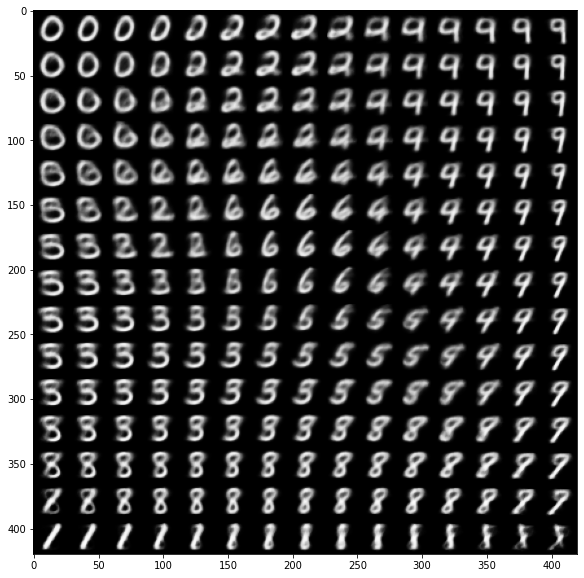

In [19]:
from scipy.stats import norm
#用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
vae.eval()
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #sample 出隐变量
        z_sample = np.array([[xi, yi]])
        #解码
        x_decoded= vae.decoder(torch.tensor(z_sample).float().to(device))
        digit = x_decoded.reshape(digit_size, digit_size).detach().numpy() 
        #保存图片
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
